## INTRODUCTION

This notebook aims to predict the revenue from the content of the TMDB dataset that contains around 5000 movies and TV series. 

The contents of this notebook are as follows:

1.Load Dataset and clean data : This section will revolve around exploring the data.(1)JSON format (2)Dropping Null & NA columns (3)Dropping Unnecessary Columns (4)Converting data into numeric label types (5)Statistics of each features

2.Data Analysis: visualising some summary statistics.

3.Feature Selection: Use Heat map to see the correlation between features and use PCA to calculate number of features to select

4.Regression:Implementing 6 of Sklearn's linear models (Linear Regression, KNeighbors Regression, Decision Tree Regression, Random Forest Regression, Gradient Boosting Regression, Kernel Ridge Regression
) and counts Mean absolute error, Mean squared error, Median squared error and R².

5.Classification:Implementing 4 classification models (Random Forest, Naïve Bayes, SVM, Decision Tree) and counts accuracy.

6.Prediction and Conclusion 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## 1. Data Cleaning

### 1.1 Reading data from csv files and merge them into ONE dataframe

In [2]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews',
                ]

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'revenue',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'original_language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    directors_gender = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors,[0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    tmdb_movies['month'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.month)
    tmdb_movies['day'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.day)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    # tmdb_movies['language_1'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'iso_639_1']))
    # tmdb_movies['language_2'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [1, 'iso_639_1']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_1_id'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'id']))
    tmdb_movies['actor_2_id'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'id']))
    tmdb_movies['actor_3_id'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'id']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    # tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    # tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    # tmdb_movies['genres'] = tmdb_movies['genres'].apply(lambda x: safe_access(x, [0,"id"]))
    # tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(lambda x: safe_access(x, [0, 'name']))
    return tmdb_movies

In [3]:
movies = load_tmdb_movies("tmdb_5000_movies.csv")
credits = load_tmdb_credits("tmdb_5000_credits.csv")
data = convert_to_original_format(movies, credits)

In [4]:
# data.value_counts().plot(kind='bar')
# sns.countplot(data.value_count())
# plt.plot(data.)
# plt.plot(model_name,score_array)
columns_Title = pd.DataFrame(data.columns)

In [5]:
len(data.columns)

32

In [6]:
data5 = data.head()
df1_transposed = data5.T
df2 = pd.DataFrame(df1_transposed.loc[:,1])
df2

,1
budget,300000000
genres,Adventure
homepage,http://disney.go.com/disneypictures/pirates/
id,285
plot_keywords,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na..."
original_language,en
original_title,Pirates of the Caribbean: At World's End
overview,"Captain Barbossa, long believed to be dead, ha..."
popularity,139.083
production_companies,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'..."


### 1.2 Dropping unnessary columns and rows

In [7]:
new_data = data.drop(["id",
                      "homepage",
                      "overview",
                      "spoken_languages",
                      "status", 
                      "tagline", 
                      "original_title", 
                      "production_companies", 
                      "production_countries", 
                      "movie_title", 
                      "release_date",
                      "plot_keywords"], 1)
len(new_data.columns)

20

### 1.3 Show number of nulls in each fields

In [8]:
print("Missing Value in different columns")
new_data.isnull().sum()

Missing Value in different columns


budget                 0
genres                28
original_language      0
popularity             0
revenue                0
duration               2
vote_average           0
num_voted_users        0
year                   1
month                  1
day                    1
country              174
director_name         30
actor_1_name          43
actor_2_name          53
actor_3_name          63
actor_1_id            43
actor_2_id            53
actor_3_id            63
companies_1          351
dtype: int64

### 1.4 Droping rows contains nulls

In [9]:
new_data = new_data.dropna()
new_data.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
revenue              0
duration             0
vote_average         0
num_voted_users      0
year                 0
month                0
day                  0
country              0
director_name        0
actor_1_name         0
actor_2_name         0
actor_3_name         0
actor_1_id           0
actor_2_id           0
actor_3_id           0
companies_1          0
dtype: int64

In [10]:
len(new_data)


4411

### 1.5 Converting string fields into label type

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

name_list = []
id_list = []
allTable = pd.DataFrame()
string_list = ["original_language", "country", "companies_1","director_name","genres"]

for x in string_list:
    new_data[x] = le.fit_transform(new_data[x].astype("str"))

    for (k,v) in enumerate(le.classes_):
        name_list.append(v)
        id_list.append(k)
        
#     id_name_list = (name_list,id_list)  
    allTable[x] = pd.Series(name_list)
    allTable[x+" id"] = pd.Series(id_list)
    #print(allTable)
    name_list.clear()
    id_list.clear()
    
allTable

,original_language,original_language id,country,country id,companies_1,companies_1 id,director_name,director_name id,genres,genres id
0,af,0,Afghanistan,0,100 Bares,0,Aaron Hann,0,Action,0.0
1,ar,1,Argentina,1,101st Street Films,1,Aaron Schneider,1,Adventure,1.0
2,cn,2,Aruba,2,1492 Pictures,2,Abel Ferrara,2,Animation,2.0
3,da,3,Australia,3,1818,3,Adam Brooks,3,Comedy,3.0
4,de,4,Austria,4,19 Entertainment,4,Adam Carolla,4,Crime,4.0
5,el,5,Bahamas,5,21 Laps Entertainment,5,Adam Green,5,Documentary,5.0
6,en,6,Belgium,6,26 Films,6,Adam Jay Epstein,6,Drama,6.0
7,es,7,Bhutan,7,2929 Productions,7,Adam Marcus,7,Family,7.0
8,fa,8,Bolivia,8,3 Arts Entertainment,8,Adam McKay,8,Fantasy,8.0
9,fr,9,Bosnia and Herzegovina,9,30 Something Productions,9,Adam Rapp,9,Foreign,9.0


In [12]:
table_actor = new_data.loc[:,["actor_1_name","actor_1_id","actor_2_name","actor_2_id","actor_3_name","actor_3_id"]]
new_data = new_data.drop(["actor_1_name","actor_2_name","actor_3_name"],1)
table_actor

,actor_1_name,actor_1_id,actor_2_name,actor_2_id,actor_3_name,actor_3_id
0,Sam Worthington,65731.0,Zoe Saldana,8691.0,Sigourney Weaver,10205.0
1,Johnny Depp,85.0,Orlando Bloom,114.0,Keira Knightley,116.0
2,Daniel Craig,8784.0,Christoph Waltz,27319.0,Léa Seydoux,121529.0
3,Christian Bale,3894.0,Michael Caine,3895.0,Gary Oldman,64.0
4,Taylor Kitsch,60900.0,Lynn Collins,21044.0,Samantha Morton,2206.0
5,Tobey Maguire,2219.0,Kirsten Dunst,205.0,James Franco,17051.0
6,Zachary Levi,69899.0,Mandy Moore,16855.0,Donna Murphy,2517.0
7,Robert Downey Jr.,3223.0,Chris Hemsworth,74568.0,Mark Ruffalo,103.0
8,Daniel Radcliffe,10980.0,Rupert Grint,10989.0,Emma Watson,10990.0
9,Ben Affleck,880.0,Henry Cavill,73968.0,Gal Gadot,90633.0


### 1.6 Splitting the data into x and y

In [13]:

y = new_data.loc[:, 'revenue']
X = new_data.drop("revenue",axis=1)

## 2. Feature Selection

###      2.1 Show correlation through heat map 

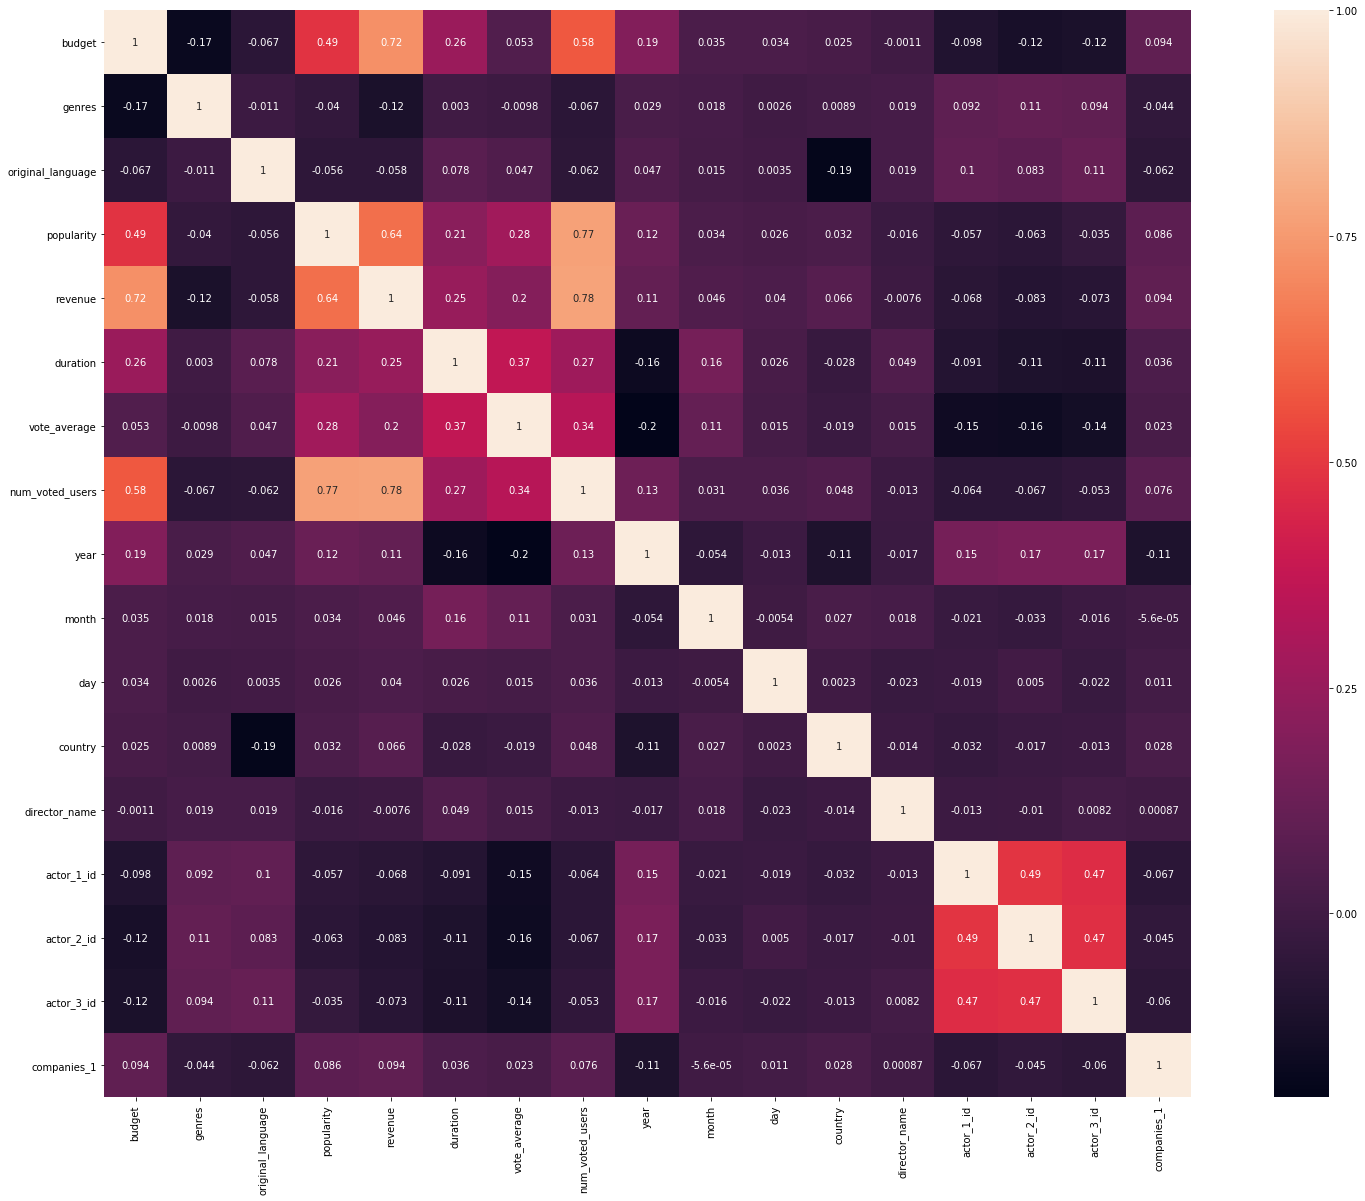

In [14]:
# Drawing the correlation figure
fig = plt.subplots(figsize = (30,20))
# sns.set(font_scale = 1.5)
sns.heatmap (new_data.corr(), square = True, cbar = True, annot = True, annot_kws = {'size': 10})
plt.show()

### 2.2 Table of revenue with correlation of each feature  


In [15]:
corr_revenue =pd.DataFrame(new_data.corrwith(y))
corr_revenue.columns =["Correlation with Revenue"]
corr_revenue.sort_values(by = "Correlation with Revenue", ascending = False)

,Correlation with Revenue
revenue,1.000000
num_voted_users,0.776179
budget,0.724133
popularity,0.635208
duration,0.250271
vote_average,0.198309
year,0.105633
companies_1,0.094396
country,0.066420
month,0.045793


### 2.3 Apply PCA and plot number of components vs variance 

Text(0, 0.5, 'cumulative explained variance')

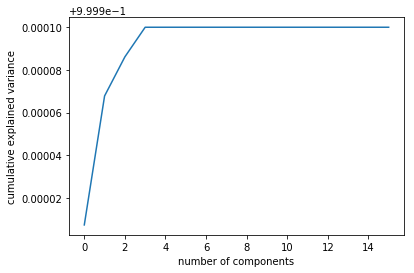

In [16]:
from sklearn.decomposition import PCA
from sklearn import metrics
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### 2.4 Select number of important feature


In [17]:
pca = PCA(n_components=.999999)
X =pca.fit_transform(X)
X.shape


(4411, 4)

## 3. Data Scaling and splitting

### 3.1 Shape x and y data

In [18]:
print(X.shape)
print(y.shape)

(4411, 4)
(4411,)


### 3.2 Select important features as x and revenue for y

In [19]:
y = new_data.loc[:, 'revenue']
X = new_data.loc[:, ['budget', 'popularity', 'duration', 'num_voted_users']]
act_rev = y[7]
act_rev

1405403694

### 3.3 Splitting training and testing datasets

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
print(X_train.shape)
print(y_train.shape)

(3528, 4)
(3528,)


### 3.4 Scaling training data set

In [22]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## 4. Regression

### Evaluation regression function

In [23]:
'''Explained variance score'''
'''The best possible score is 1.0, lower values are worse.'''
from sklearn.metrics import explained_variance_score
# print(explained_variance_score(y_test, y_pred))
'''Mean absolute error'''
from sklearn.metrics import mean_absolute_error
# print(mean_absolute_error(y_test, y_pred))
'''Mean squared error'''
from sklearn.metrics import mean_squared_error
# print(mean_squared_error(y_test, y_pred))
'''Mean squared logarithmic error'''
from sklearn.metrics import mean_squared_log_error
# print(mean_squared_log_error(y_test, y_pred))
'''Median absolute error'''
from sklearn.metrics import median_absolute_error
# print(median_absolute_error(y_test, y_pred))
'''R² score, the coefficient of determination'''
'''Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).'''
from sklearn.metrics import r2_score
# print(r2_score(y_test, y_pred))
score_array =[]
R_square_array = []
model_name = []
model_R_name = []


def evaluate_regression(y_test, y_pred):
    output = "Explained variance score: {}\n".format(explained_variance_score(y_test, y_pred))
    output += "Mean absolute error: {}\n".format(mean_absolute_error(y_test, y_pred))
    output += "Mean squared error: {}\n".format(mean_squared_error(y_test, y_pred))
    # output += "Mean squared logarithmic error: {}\n".format(mean_squared_log_error(y_test, y_pred))
    output += "Median squared error: {}\n".format(median_absolute_error(y_test, y_pred))
    R_square_array.append(r2_score(y_test, y_pred))
    output += "R² score: {}\n".format(r2_score(y_test, y_pred))
    return output

In [24]:
def plotting(y_test, y_pred, title, r_square):
    # Plot the results
    plt.figure()
    plt.scatter(y_test, y_pred, c='r')
    plt.scatter(y_test, y_test)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.legend(('predicted', 'actual'), loc='lower right')
    plt.title("{} -> R²: {}".format(title, round(r_square, 2)))
    plt.show()

### Regression Function

In [25]:
def fit_data(regressor):
    print('================{}=================='.format(str(regressor.__class__.__name__)))
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print(evaluate_regression(y_test, y_pred))
    model_R_name.append(str(regressor.__class__.__name__))
    plotting(y_test, y_pred, str(regressor.__class__.__name__), r2_score(y_test, y_pred))
    print('================{}=================='.format(str(regressor.__class__.__name__)))

### 4.1 Apply regression and plot its results

================LinearRegression==================
Explained variance score: 0.657831079284042
Mean absolute error: 49454348.75751676
Mean squared error: 8025373373806040.0
Median squared error: 22159775.684315264
R² score: 0.657663805636847



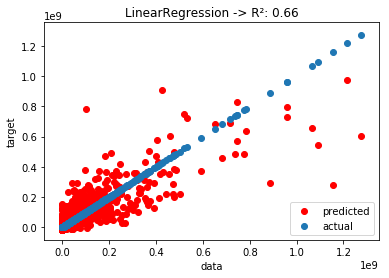

================LinearRegression==================
================KNeighborsRegressor==================
Explained variance score: 0.6942197479616523
Mean absolute error: 45449363.99207248
Mean squared error: 7172345669189518.0
Median squared error: 18833624.8
R² score: 0.6940511790938733



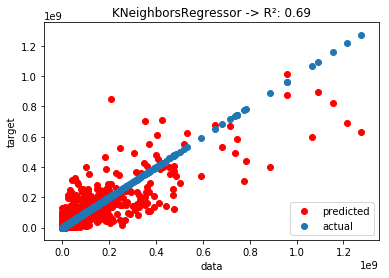

================KNeighborsRegressor==================
================DecisionTreeRegressor==================
Explained variance score: 0.6793529956626294
Mean absolute error: 46207892.188219115
Mean squared error: 7517225160524576.0
Median squared error: 19699805.522633746
R² score: 0.6793397473537759



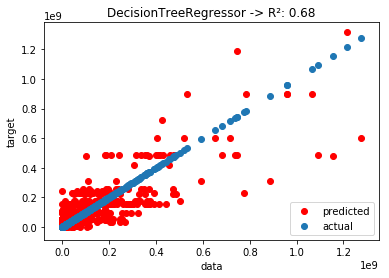

================DecisionTreeRegressor==================
================RandomForestRegressor==================
Explained variance score: 0.7121144588579595
Mean absolute error: 43528076.086799875
Mean squared error: 6752936579619048.0
Median squared error: 17670425.57669983
R² score: 0.7119417998684152



C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


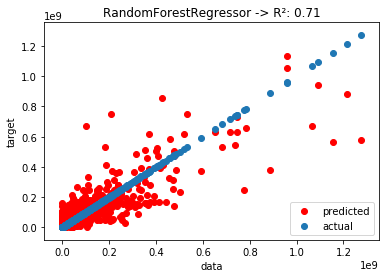

================RandomForestRegressor==================
================GradientBoostingRegressor==================
Explained variance score: 0.7034524818599162
Mean absolute error: 44342157.4579963
Mean squared error: 6952224752969181.0
Median squared error: 17467255.19097717
R² score: 0.7034408178369819



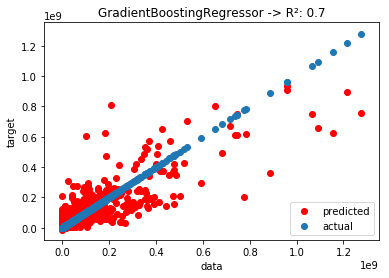

================GradientBoostingRegressor==================
================KernelRidge==================
Explained variance score: 0.6692078508466224
Mean absolute error: 44334423.25539182
Mean squared error: 7758780133002075.0
Median squared error: 19375100.01394868
R² score: 0.6690358018355094



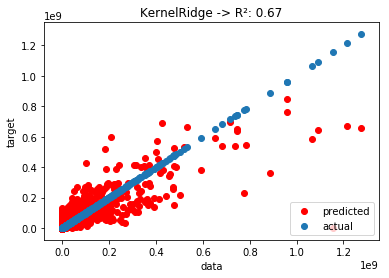

================KernelRidge==================


In [26]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

regressor_list = [linear_model.LinearRegression(),
                  KNeighborsRegressor(),
                  DecisionTreeRegressor(max_depth=5, random_state=10),
                  RandomForestRegressor(max_depth=5, random_state=10),
                  GradientBoostingRegressor(max_depth=5, random_state=10),
                  KernelRidge(kernel='rbf', gamma=0.1)]
for regressor in regressor_list:
    fit_data(regressor)

In [27]:
#This shows the score array for each regression shown on the list in order
print(score_array)

[]


## 5. Classification

### Preprocess stage

>**Evaluation classification function**

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluate_classification(y_test, y_pred,name):
    RFcm = confusion_matrix(y_test, y_pred)
    print("confusion matrix:")
    print(RFcm)
    print('accuracy_score',accuracy_score(y_test, y_pred)) 
    score_array.append(accuracy_score(y_test, y_pred))
    model_name.append(name)

In [29]:
# y = new_data.loc[:, 'revenue']
# X = new_data.loc[:, ['budget', 'popularity', 'duration', 'num_voted_users']]
df = pd.concat([X, y], axis=1)

In [30]:
df.shape

(4411, 5)

>**Get information about the revenue**

In [31]:
y.describe()

count    4.411000e+03
mean     8.949506e+07
std      1.680391e+08
min      0.000000e+00
25%      1.250000e+01
50%      2.601086e+07
75%      1.017303e+08
max      2.787965e+09
Name: revenue, dtype: float64

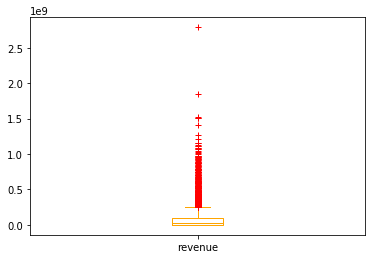

In [32]:
df['revenue'].plot.box(color='orange', sym='r+')

>**Convert revenue into four categories**


In [33]:
from sklearn.cluster import KMeans
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

In [34]:
df_r=np.array(df['revenue']).reshape(-1, 1)
print(df_r)

[[2787965087]
 [ 961000000]
 [ 880674609]
 ...
 [   2040920]
 [         0]
 [         0]]


In [35]:
score = [kmeans[i].fit(df_r).score(df_r) for i in range(len(kmeans))]

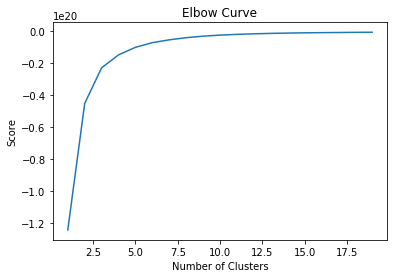

In [36]:
import pylab as pl
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Fit K-Means clustering for k=5

In [37]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_r)
len(kmeans.labels_)

4411

In [38]:
df['revenue_cat']= kmeans.labels_
df.head()

,budget,popularity,duration,num_voted_users,revenue,revenue_cat
0,237000000,150.437577,162.0,11800,2787965087,4
1,300000000,139.082615,169.0,4500,961000000,3
2,245000000,107.376788,148.0,4466,880674609,3
3,250000000,112.312950,165.0,9106,1084939099,3
4,260000000,43.926995,132.0,2124,284139100,0


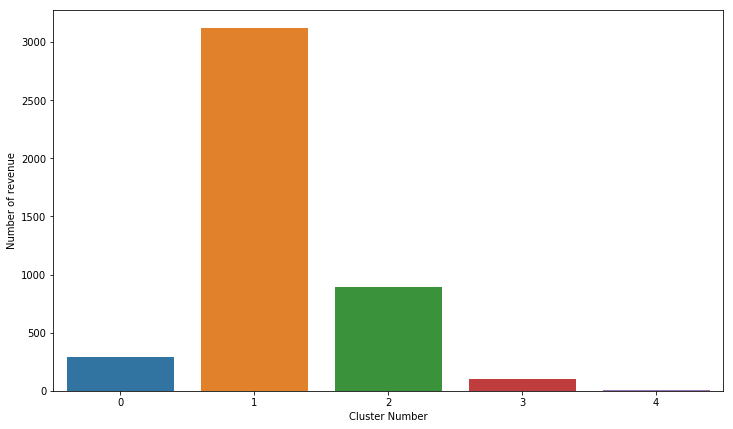

In [39]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x=np.arange(0,5,1),y=df.groupby(['revenue_cat']).count()['revenue'].values)
x=axis.set_xlabel("Cluster Number")
y=axis.set_ylabel("Number of revenue")

In [40]:
df.groupby(['revenue_cat']).mean()

,budget,popularity,duration,num_voted_users,revenue
revenue_cat,,,,,
0,9.529423e+07,59.118909,117.539249,2611.870307,3.822944e+08
1,1.584785e+07,13.244386,105.614694,303.382098,1.822760e+07
2,5.045032e+07,34.932267,112.176734,1155.751678,1.484357e+08
3,1.506683e+08,115.877992,127.722772,5082.386139,8.183742e+08
4,2.128333e+08,175.037018,150.166667,8457.166667,1.762957e+09


In [41]:
a= df.groupby(['revenue_cat']).min()
df

,budget,popularity,duration,num_voted_users,revenue,revenue_cat
0,237000000,150.437577,162.0,11800,2787965087,4
1,300000000,139.082615,169.0,4500,961000000,3
2,245000000,107.376788,148.0,4466,880674609,3
3,250000000,112.312950,165.0,9106,1084939099,3
4,260000000,43.926995,132.0,2124,284139100,0
5,258000000,115.699814,139.0,3576,890871626,3
6,260000000,48.681969,100.0,3330,591794936,0
7,280000000,134.279229,141.0,6767,1405403694,4
8,250000000,98.885637,153.0,5293,933959197,3
9,250000000,155.790452,151.0,7004,873260194,3


In [42]:
df.groupby(['revenue_cat']).max()

,budget,popularity,duration,num_voted_users,revenue
revenue_cat,,,,,
0,270000000,434.278564,238.0,10099,599045960
1,160000000,192.528841,338.0,8205,83615414
2,255000000,146.757391,197.0,9413,264218220
3,380000000,875.581305,201.0,13752,1274219009
4,280000000,418.708552,194.0,11800,2787965087


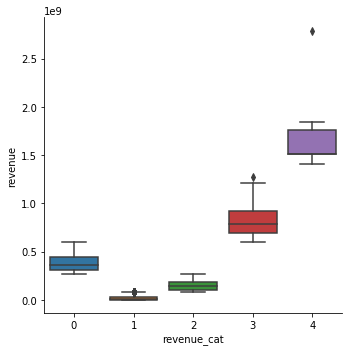

In [43]:
sns.catplot(x="revenue_cat", y="revenue", kind="box", data=df)

In [44]:
#sns.catplot(x="revenue_cat", y="revenue", kind="swarm", data=df)

>**Plot revenue cluster type vs number of movies**

> Note: Cluster number in the x-axis represents the four revenue clusters (high, mid high, mid low, low) while the y-axis represents how many movies are within the cluster range

>**Using the categorical revenue (revenue_cat) as data for y**

In [45]:
X = df.drop(['revenue_cat', 'revenue'], axis = 1)
y = df['revenue_cat']

In [46]:
X

,budget,popularity,duration,num_voted_users
0,237000000,150.437577,162.0,11800
1,300000000,139.082615,169.0,4500
2,245000000,107.376788,148.0,4466
3,250000000,112.312950,165.0,9106
4,260000000,43.926995,132.0,2124
5,258000000,115.699814,139.0,3576
6,260000000,48.681969,100.0,3330
7,280000000,134.279229,141.0,6767
8,250000000,98.885637,153.0,5293
9,250000000,155.790452,151.0,7004


In [47]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [48]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## 5.1 Random Forest Classifier

In [49]:
X_train.shape

(3528, 4)

In [50]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 10, criterion='entropy', random_state = 0)
RFC.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
y_pred = RFC.predict(X_test)

In [52]:
evaluate_classification(y_test, y_pred,"Random Forest")


confusion matrix:
[[ 22   4  29   2]
 [  5 572  49   0]
 [ 17  62 103   2]
 [  6   0   1   9]]
accuracy_score 0.7995469988674971


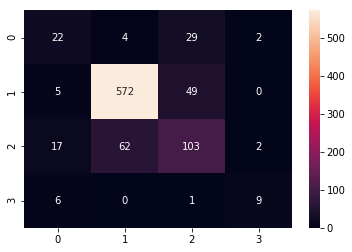

In [53]:
RFcm = confusion_matrix(y_test, y_pred)
sns.heatmap(RFcm, annot=True, fmt="d")

## 5.2 Naive Bayes


In [54]:
# Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
# Predicting the Test set results
y_pred = NB.predict(X_test)

In [56]:
evaluate_classification(y_test, y_pred,"Naive Bayes")

confusion matrix:
[[ 25   3  26   3]
 [  5 571  49   1]
 [ 11  73  98   2]
 [  6   0   1   9]]
accuracy_score 0.796149490373726


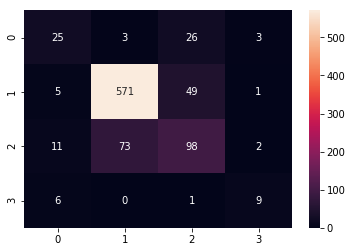

In [57]:
NBcm = confusion_matrix(y_test, y_pred)
sns.heatmap(NBcm, annot=True, fmt="d")


## 5.3 SVM

In [58]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
SVM = SVC(kernel = 'linear', random_state = 0)
SVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [59]:
# Predicting the Test set results
y_pred = SVM.predict(X_test)

In [60]:
evaluate_classification(y_test, y_pred,"SVM-linear")

confusion matrix:
[[ 21   5  28   3]
 [  0 588  38   0]
 [  8  82  93   1]
 [  7   0   0   9]]
accuracy_score 0.8052095130237825


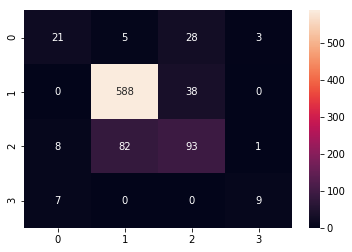

In [61]:
SVMcm = confusion_matrix(y_test, y_pred)
sns.heatmap(SVMcm, annot=True, fmt="d")

## 5.4 Decision Tree Classifier 

In [62]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion='entropy', random_state = 0)
DT.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [63]:
# Predicting the Test set results

y_pred = DT.predict(X_test)
#print(y_pred)

In [64]:
evaluate_classification(y_test, y_pred,"Decision Tree")

confusion matrix:
[[ 22   4  29   2   0]
 [  6 549  70   1   0]
 [ 20  65  95   4   0]
 [  5   0   1   9   1]
 [  0   0   0   0   0]]
accuracy_score 0.7644394110985278


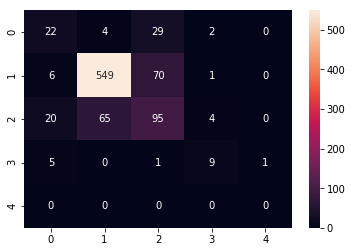

In [65]:
DTcm = confusion_matrix(y_test, y_pred)
sns.heatmap(DTcm, annot=True, fmt="d")

## 6. Model accuracy

In [66]:
score_table =pd.DataFrame(score_array,model_name)
score_table.columns = ["Accuracy"]
score_table.sort_values(by="Accuracy",ascending = False)



,Accuracy
SVM-linear,0.805210
Random Forest,0.799547
Naive Bayes,0.796149
Decision Tree,0.764439


In [67]:
R_table =pd.DataFrame(R_square_array,model_R_name)
R_table.columns = ["R^2"]
R_table.sort_values(by="R^2",ascending = False)

# score_array =[]
# R_square_array = []
# model_name = []
# model_R_name = []

,R^2
RandomForestRegressor,0.711942
GradientBoostingRegressor,0.703441
KNeighborsRegressor,0.694051
DecisionTreeRegressor,0.679340
KernelRidge,0.669036
LinearRegression,0.657664


### Plot model types vs score

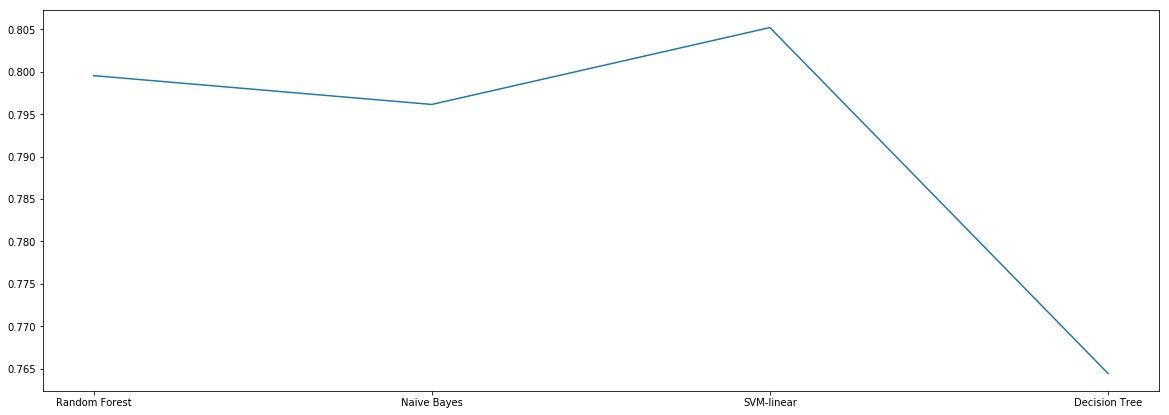

In [68]:
plt.figure(figsize=(20,7))
plt.plot(model_name,score_array)

## 7. Predication

### Get max and min for each features

In [69]:
# max_value = X.describe().loc[['max']]
# min_value = X.describe().loc[['min']]
# # max_value = max_value.drop(columns=["revenue"])
# # min_value = min_value.drop(columns=["revenue"])
# max_value.info()


pred_row = X.loc[[7],:]
act_ans = y.loc[7]

# a = pred_row.T
# pd.DataFrame(pred_row.T)
pred_row
# pred_row.shape

,budget,popularity,duration,num_voted_users
7,280000000,134.279229,141.0,6767


In [70]:
act_rev 

1405403694

In [71]:
lin = linear_model.LinearRegression()
lin.fit(X_train, y_train)
lin_output = lin.predict(pred_row)

### 7.1 Prediction for Random Forest

In [72]:
#RFC.predict(pred_row)

### 7.1 Prediction for SVM

In [73]:
SVM_output = SVM.predict(pred_row)
# pred_row["predict"] = SVM_output


### 7.2 Prediction for Naive Bayes

In [74]:
# NB_output = NB.predict(pred_row)


### 7.3 Prediction for Random Forest Regression

In [75]:
rf = RandomForestRegressor(max_depth=5, random_state=10)
rf.fit(X_train,y_train)

rf_output =rf.predict(pred_row)
rf_output
# pred_output = pd.DataFrame(pred_output).values

#['budget','popularity', 'duration', 'num_voted_users']

C:\Users\Dr. Ir. Bala Kumar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([3.70151515])

In [76]:

# max_value["predict"]=pred_max
# min_value["predict"]=pred_min
# pd.concat([pred_row,pred_output],axis=1)
print("FOR SVM")
pred_row["predict"] = SVM_output
pred_row["actual"] = act_ans
pred_row

FOR SVM


,budget,popularity,duration,num_voted_users,predict,actual
7,280000000,134.279229,141.0,6767,4,4


In [77]:
pred_row = pred_row.drop(columns=["predict"])
pred_row = pred_row.drop(columns=["actual"])
print("FOR RF")
pred_row["predict"] = rf_output
pred_row["actual"] = act_ans
pred_row

FOR RF


,budget,popularity,duration,num_voted_users,predict,actual
7,280000000,134.279229,141.0,6767,3.701515,4


In [78]:
pred_row = pred_row.drop(columns=["predict"])
pred_row = pred_row.drop(columns=["actual"])
print("FOR LINEAR REG")
pred_row["predict"] = lin_output
pred_row["actual"] = act_rev
pred_row

FOR LINEAR REG


,budget,popularity,duration,num_voted_users,predict,actual
7,280000000,134.279229,141.0,6767,1.982712e+07,1405403694


## Conclusion

We tried to run the classification and regression model for prediction
Classification gave us the range of the revenue
Regression gave us the exact number of the revenue
We believe classifier model is the most reliable model among the rest
